<a href="https://colab.research.google.com/github/nahyeon-an/python/blob/main/ML/time-series/Seasonality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Seasonality  
regular, periodic change (반복적인, 주기적인 변화)  
일반적으로 시간, 캘린더를 따름 (day, week, year 에 걸친 반복)  
day, year에 걸친 현실세계의 순환에 따라 발생  
사회의 전통, 컨벤션에 의해 발생  

Seasonality model 2가지를 배워보자  
- indicators : 관찰로 얻는 계절성 (ex. 관측치를 관찰하여 weekly seasonality 를 얻음)  
- fourier feature : 많은 관측치에 대한 season  

## Seasonal plot 과 Seasonal indicators  
trend 를 찾기 위해 moving average 를 사용했던 것처럼, seasonal pattern 을 찾기위해 seasonal plot 을 사용하자  

seasonal plot  
- 시계열의 일부분을 잘라서 보는 것  
- 관찰하고 싶은 season 을 잘라서 봄  

seasonal indicator  
- binary feature  
- seasonal difference 를 나타냄  
- seasonal period 를 카테고리형 피처화할 때 얻게되는 값  
- ex) day 에 one-hot encoding 적용하면 weekly seasonal indicator 를 얻게됨   
- training data 에 추가해 seasonal period 의 평균을 구별해낼 수 있음  

## Fourier Features   
Fourier Feature  
- 더 긴 기간, 더 많은 관측치에 적합한 feature  
- 각 날짜마다 feature 를 만드는 것이 아닌, seasonal curve 의 전체적인 shape 을 만드는 것이 목적  

연간 3번의 아주 긴 movement, 연간 52번의 짧은 weekly movement  
- fourier feature를 이용해 캐치하려는 계절의 frequency  

우리가 만들어낼 모델의 계절과 동일한 frequency를 가지는 주기적인 커브를 훈련데이터에 포함시키려는 아이디어  
우리가 사용하려는 주기적인 커브가 사인과 코사인  

그래서 Fourier feature 라는 건  
- sin, cos 곡선의 쌍 (pair)  
- 잠재적인 frequency 에 대해 가장 긴 것으로 시작하는 쌍  
- 푸리에 쌍은 frequency 빈도를 가짐  

sin, cos 곡선을 훈련셋에 추가한다면, linear regression 알고리즘은 목표값의 계절성 요소를 학습한 가중치를 찾아냄  

## Periodogram 을 이용하여 Fourier Feature 추출하기  
우리의 feature 에 과연 푸리에 쌍을 몇 개 포함시킬 수 있을까?  
periodogram : 시계열에서 frequency 의 강도를 나타냄  
- y = (a \*\* 2 + b \*\* 2) / 2  
- a, b : sin, cos 의 coefficient  
- x 축엔 frequency  

In [2]:
import numpy as np

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

## Example  

In [3]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

In [4]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [5]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [6]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [8]:
tunnel = pd.read_csv('tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period('D')

In [9]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [10]:
X = tunnel.copy()
X['day'] = X.index.dayofweek
X['week'] = X.index.week
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

X.head()

,NumVehicles,day,week,dayofyear,year
Day,,,,,
2003-11-01,103536,5,44,305,2003
2003-11-02,92051,6,44,306,2003
2003-11-03,100795,0,45,307,2003
2003-11-04,102352,1,45,308,2003
2003-11-05,106569,2,45,309,2003


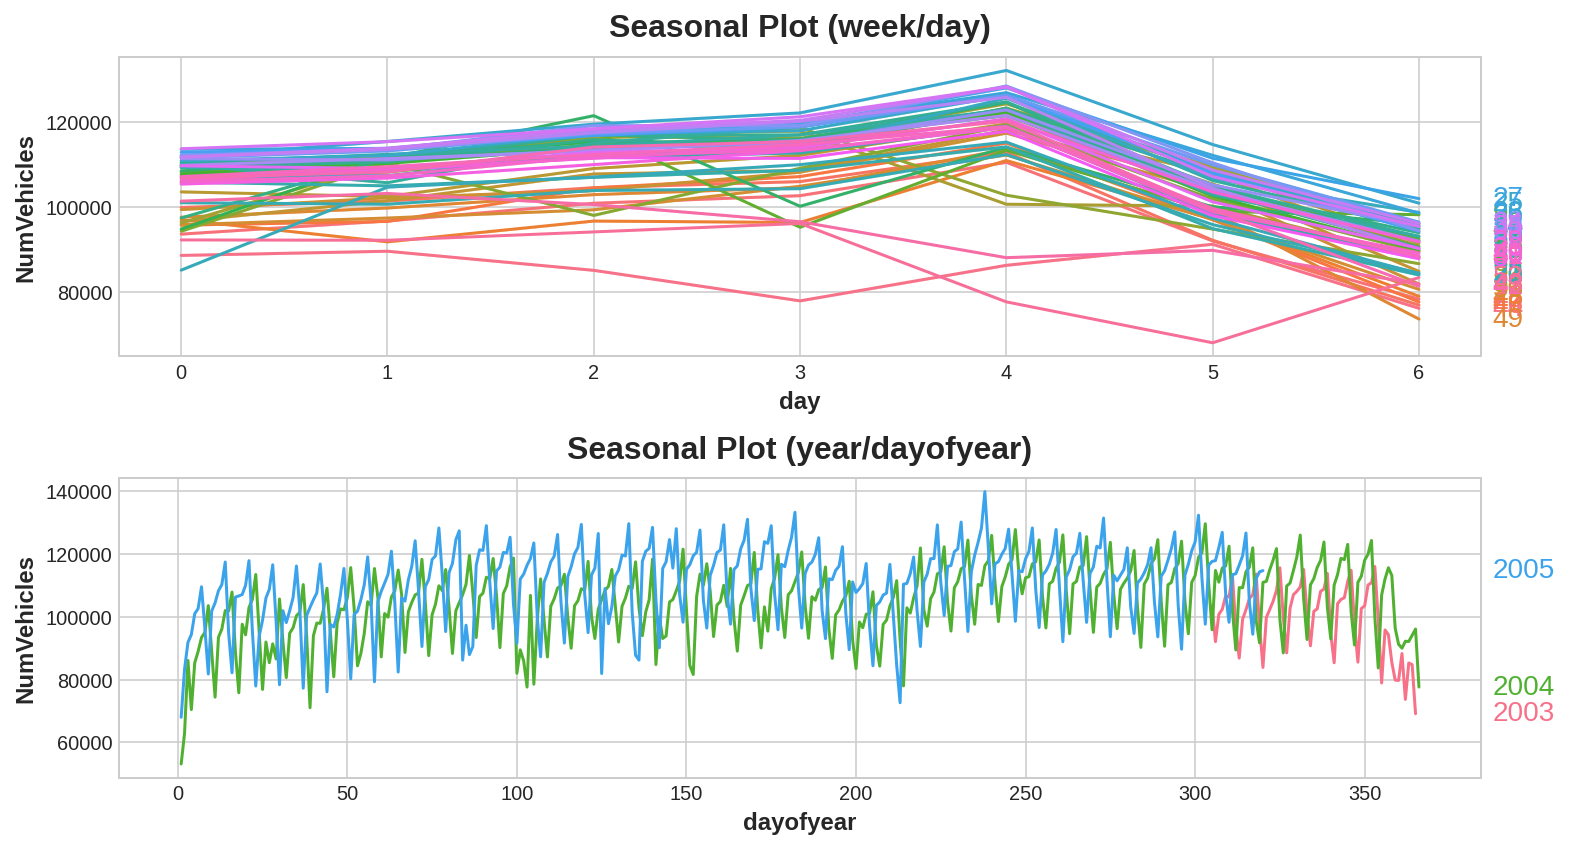

In [11]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1)

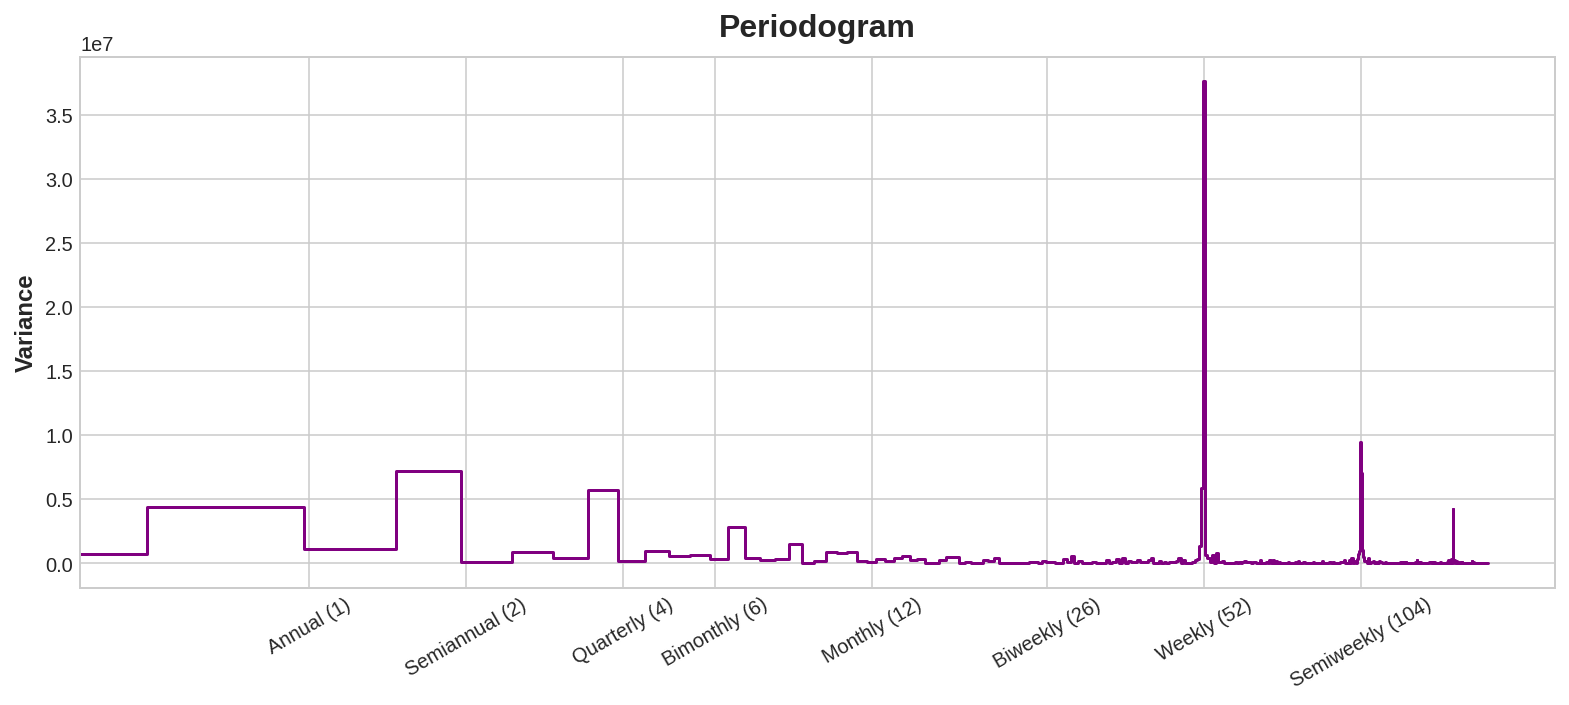

In [12]:
plot_periodogram(tunnel.NumVehicles)

seasonal feature 를 DeterministicProcess 를 이용해서 만들어보자

In [13]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# 10 sin/cos pairs
# A : Annual seasonality
fourier = CalendarFourier(freq="A", order=10)  

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,  # dummy feature for bias, y 교차점
    order=1,  # trend, order == 1은 linear 를 의미
    seasonal=True,  # weekly seasonality, indicator
    additional_terms=[fourier],  # annual seasonality, fourier
    drop=True,  # drop terms to avoid collinearity
)

# tunnel.index 의 날짜에 대한 feature 를 생성
X = dp.in_sample()

X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


feature 가 만들어졌으므로, 모델을 학습하여 예측해보자

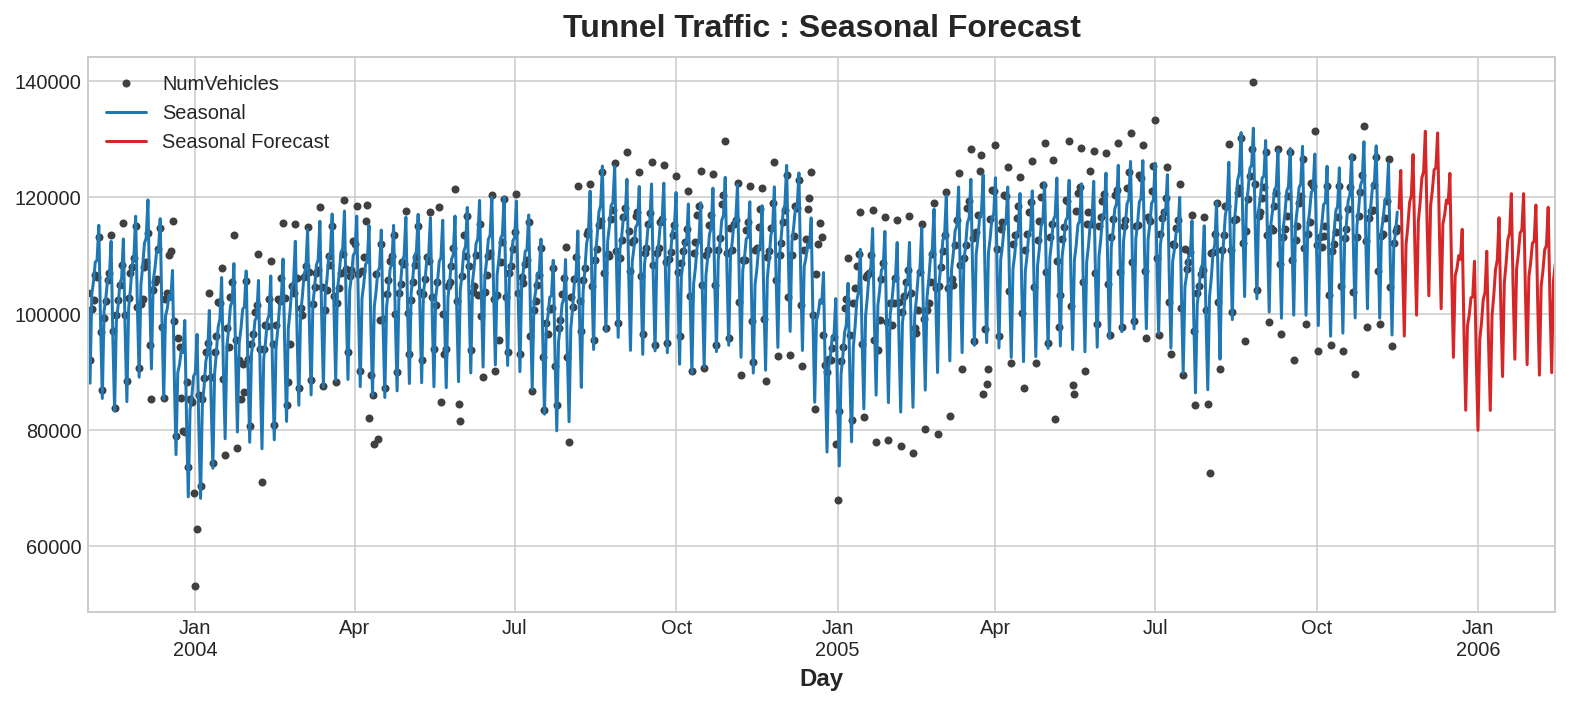

In [14]:
y = tunnel['NumVehicles']

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)

# 90 일치 feature 생성
X_forecast = dp.out_of_sample(steps=90)
# 생성한 데이터에 대한 예측
y_forecast = pd.Series(model.predict(X_forecast), index=X_forecast.index)

# 시각화
ax = y.plot(color='0.25', style='.', title='Tunnel Traffic : Seasonal Forecast')
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_forecast.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax.legend()